GPflow with TF2.0
===

##### Small steps big changes

<br>



In [27]:
from typing import Tuple, Optional
from pathlib import Path

import datetime
import io
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import gpflow

from gpflow.config import default_float

import warnings

warnings.filterwarnings('ignore')

Make `tensorbord` work inside notebook:

In [5]:
output_logdir = "/tmp/tensorboard"

!rm -rf "{output_logdir}"
!mkdir "{output_logdir}"

%load_ext tensorboard
%matplotlib inline


def enumerated_logdir(_logdir_id: int = [0]):
    logdir = Path(output_logdir, str(_logdir_id[0]))
    _logdir_id[0] += 1
    return str(logdir)

Setup random seeds and default float for `gpflow` tensors:

In [7]:
gpflow.config.set_default_float(np.float64)
np.random.seed(0)
tf.random.set_seed(0)

## Loading data using TensorFlow Datasets

For this example, we create a synthetic dataset (noisy sine function) 

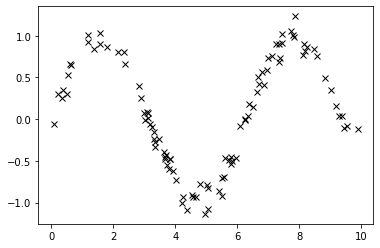

In [8]:
def noisy_sin(x): 
    return tf.math.sin(x) + 0.1 * tf.random.normal(x.shape, dtype=default_float())

num_train_data, num_test_data = 100, 500

X = tf.random.uniform((num_train_data, 1), dtype=default_float()) * 10
Xtest = tf.random.uniform((num_test_data, 1), dtype=default_float()) * 10

Y = noisy_sin(X)
Ytest = noisy_sin(Xtest)

plt.plot(X, Y, 'xk')
plt.show()

Working with Tensorflow Datasets is an efficient way to rapidly shuffle, iterate and batch from data.

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
test_dataset = tf.data.Dataset.from_tensor_slices((Xtest, Ytest))

batch_size = 32
num_features = 10
prefetch_size = num_train_data // 2
shuffle_buffer_size = num_train_data // 2
num_batches_per_epoch = num_train_data // batch_size

original_train_dataset = train_dataset
train_dataset = train_dataset.repeat()\
                    .prefetch(prefetch_size)\
                    .shuffle(buffer_size=shuffle_buffer_size)\
                    .batch(batch_size)

print(f"prefetch_size={prefetch_size}")
print(f"shuffle_buffer_size={shuffle_buffer_size}")
print(f"num_batches_per_epoch={num_batches_per_epoch}")

W0913 09:44:28.191930 4664387008 deprecation.py:323] From /Users/artemav/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow_core/python/data/util/random_seed.py:58: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


prefetch_size=50
shuffle_buffer_size=50
num_batches_per_epoch=3


## Define a GP model

In GPflow2.0, we use `tf.Module` to build all our models, as well as, their components (kernels, likelihoods, parameters, etc.). 

In [10]:
kernel = gpflow.kernels.RBF(variance=2.)
likelihood = gpflow.likelihoods.Gaussian()
features = np.linspace(0, 10, num_features).reshape(-1, 1)

model = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood, inducing_variables=features)

You can set a module (or a particular parameter) to be non-trainable using the auxiliary method ```set_trainable(module, False)```

In [11]:
from gpflow.utilities import set_trainable

set_trainable(likelihood, False)
set_trainable(kernel.variance, False)

set_trainable(likelihood, True)
set_trainable(kernel.variance, True)

We can use ```param.assign(value)``` to assign a value to a parameter:

In [12]:
kernel.lengthscale.assign(0.5)

All these changes are reflected when we use ```print_summary(model)``` to print a detailed summary of the model. By default the output will be displayed in minimalistic and simple table.

In [13]:
from gpflow.utilities import print_summary

print_summary(model)  # same as print_summary(model, fmt="simple")

name                       class      transform       trainable    shape        dtype    value
-------------------------  ---------  --------------  -----------  -----------  -------  ----------------
SVGP.kernel.variance       Parameter  Softplus        False        ()           float64  2.0
SVGP.kernel.lengthscale    Parameter  Softplus        True         ()           float64  0.5
SVGP.likelihood.variance   Parameter  Softplus        False        ()           float64  1.0
SVGP.inducing_variables.Z  Parameter                  True         (10, 1)      float64  [[0....
SVGP.q_mu                  Parameter                  True         (10, 1)      float64  [[0....
SVGP.q_sqrt                Parameter  FillTriangular  True         (1, 10, 10)  float64  [[[1., 0., 0....


We can change default printing so that it will look more nicely in our notebook:

In [14]:
gpflow.config.set_summary_fmt("notebook")

print_summary(model)  # same as print_summary(model, fmt="notebook")

name,class,transform,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,False,(),float64,2.0
SVGP.kernel.lengthscale,Parameter,Softplus,True,(),float64,0.5
SVGP.likelihood.variance,Parameter,Softplus,False,(),float64,1.0
SVGP.inducing_variables.Z,Parameter,,True,"(10, 1)",float64,[[0....
SVGP.q_mu,Parameter,,True,"(10, 1)",float64,[[0....
SVGP.q_sqrt,Parameter,FillTriangular,True,"(1, 10, 10)",float64,"[[[1., 0., 0...."


## Training using Gradient Tapes

In TensorFlow2.0, we can optimise (trainable) model parameters with Tensorflow optimizers using GradientTapes. In this simple example, we perform one gradient update of the Adam optimizer to minimize the negative marginal log likelihood (or ELBO) of our model.

In [15]:
optimizer = tf.optimizers.Adam()

with tf.GradientTape() as tape:
    tape.watch(model.trainable_variables)
    elbo = model.elbo(X, Y)
    grads = tape.gradient(elbo, model.trainable_variables)
    
optimizer.apply_gradients(zip(grads, model.trainable_variables))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

For a more elaborare example of a gradient update we can define an ```optimization_step``` that uses decorator ```tf.function``` on a closure. A closure is callable that returns the model objective evaluated at a given dataset when called.

In [16]:
def optimization_step(model: gpflow.models.SVGP, batch: Tuple[tf.Tensor, tf.Tensor]):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        elbo = model.elbo(*batch)
        grads = tape.gradient(elbo, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

We can make use the functionality of TensorFlow Datasets to define a simple training loop that iterates over batches of the training dataset: 

In [17]:
def simple_training_loop(model: gpflow.models.SVGP, epochs: int = 1, logging_epoch_freq: int = 10):
    batches = iter(train_dataset)
    tf_optimization_step = tf.function(optimization_step, autograph=False)
    for epoch in range(epochs):
        for _ in range(num_batches_per_epoch):
            tf_optimization_step(model, next(batches))

        epoch_id = epoch + 1
        if epoch_id % logging_epoch_freq == 0:
            tf.print(f"Epoch {epoch_id}: ELBO (train) {model.elbo(X, Y)}")

In [18]:
simple_training_loop(model, epochs=10, logging_epoch_freq=2)

Epoch 2: ELBO (train) 212.29663302150476
Epoch 4: ELBO (train) 211.04060658136456
Epoch 6: ELBO (train) 209.76161048220303
Epoch 8: ELBO (train) 208.46305694165406
Epoch 10: ELBO (train) 207.13941719416468


## Monitoring 

We can monitor the training procedure using TensorFlow summary. First we create a summary writer object under which we can write scalar and images.

In [20]:
from intro_to_gpflow2_plotting import plotting_regression, summary_matplotlib_image

samples_input = tf.cast(np.linspace(0, 10, 100).reshape(100, 1), default_float())

def monitored_training_loop(model: gpflow.models.SVGP, logdir: str, 
                            epochs: int = 1, logging_epoch_freq: int = 10,
                            num_samples: int = 10):
    summary_writer = tf.summary.create_file_writer(logdir)
    tf_optimization_step = tf.function(optimization_step)
    batches = iter(train_dataset)

    with summary_writer.as_default():
        for epoch in range(epochs):
            for _ in range(num_batches_per_epoch):
                tf_optimization_step(model, next(batches))

            epoch_id = epoch + 1
            if epoch_id % logging_epoch_freq == 0:
                tf.print(f"Epoch {epoch_id}: ELBO (train) {model.elbo(X, Y)}")

                mean, var = model.predict_f(samples_input)
                samples = model.predict_f_samples(samples_input, num_samples)
                fig = plotting_regression(X, Y, samples_input, mean, var, samples)
                
                summary_matplotlib_image(dict(model_samples=fig), step=epoch)
                tf.summary.scalar('elbo', data=model.elbo(X, Y), step=epoch)
                tf.summary.scalar('likelihood/variance', data=model.likelihood.variance, step=epoch)
                tf.summary.scalar('kernel/lengthscale', data=model.kernel.lengthscale, step=epoch)
                tf.summary.scalar('kernel/variance', data=model.kernel.variance, step=epoch)

In [21]:
model = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood, inducing_variables=features)

output_logdir = enumerated_logdir()
monitored_training_loop(model, output_logdir, epochs=1000, logging_epoch_freq=100)

Epoch 100: ELBO (train) 144.1003268158425
Epoch 200: ELBO (train) 118.73314230122062
Epoch 300: ELBO (train) 111.3655437033495
Epoch 400: ELBO (train) 108.96588488244478
Epoch 500: ELBO (train) 107.86750152223229
Epoch 600: ELBO (train) 107.16676225220195
Epoch 700: ELBO (train) 106.64546597598033
Epoch 800: ELBO (train) 106.24762543511272
Epoch 900: ELBO (train) 105.9467871167052
Epoch 1000: ELBO (train) 105.73645267771897


Then, we can then use TensorBoard to examine the training procedure more in detail

In [29]:
# %tensorboard --logdir "{output_logdir}"

## Checkpointing: saving and loading models

With the help of `tf.train.CheckpointManager` and `tf.train.Checkpoint`, we can checkpoint the model throughout the training procedure. Let's start with a simple example using checkpointing to save and load `tf.Variables`:

In [30]:
initial_value = 1.2
a = tf.Variable(initial_value)

Create `Checkpoint` object:

In [31]:
ckpt = tf.train.Checkpoint(a=a)
manager = tf.train.CheckpointManager(ckpt, output_logdir, max_to_keep=3)

Save `a` variable and change its value right after:

In [32]:
manager.save()
_ = a.assign(0.33)

Now we can restore old variable value:

In [33]:
print(f"Current value of variable a: {a.numpy():0.3f}")

ckpt.restore(manager.latest_checkpoint)

print(f"Value of variable a: {a.numpy():0.3f}")

Current value of variable a: 0.330
Value of variable a: 1.200


In this example below, we modify a simple training loop to save the model every 100 epochs using the `CheckpointManager`.

In [35]:
model = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood, inducing_variables=features)

def checkpointing_training_loop(model: gpflow.models.SVGP,
                                batch_size: int,
                                epochs: int,
                                manager: tf.train.CheckpointManager,
                                logging_epoch_freq: int = 100,
                                epoch_var: Optional[tf.Variable] = None,
                                step_var: Optional[tf.Variable] = None):
    tf_optimization_step = tf.function(optimization_step)
    batches = iter(train_dataset)
    
    for epoch in range(epochs):
        for step in range(num_batches_per_epoch):
            tf_optimization_step(model, next(batches))
            if step_var is not None:
                step_var.assign(epoch * num_batches_per_epoch + step + 1)
        if epoch_var is not None:
            epoch_var.assign(epoch + 1)
            
        epoch_id = epoch + 1
        if epoch_id % logging_epoch_freq == 0:
            ckpt_path = manager.save()
            tf.print(f"Epoch {epoch_id}: ELBO (train) {model.elbo(X, Y)}, saved at {ckpt_path}")

In [36]:
step_var = tf.Variable(1, dtype=tf.int32, trainable=False)
epoch_var = tf.Variable(1, dtype=tf.int32, trainable=False)
ckpt = tf.train.Checkpoint(model=model, step=step_var, epoch=epoch_var)
manager = tf.train.CheckpointManager(ckpt, output_logdir, max_to_keep=5)

print(f"Checkpoint folder path at: {output_logdir}")

checkpointing_training_loop(model, batch_size=batch_size, epochs=1000, manager=manager, epoch_var=epoch_var, step_var=step_var)

Checkpoint folder path at: /tmp/tensorboard/0
Epoch 100: ELBO (train) 107.12611073182977, saved at /tmp/tensorboard/0/ckpt-1
Epoch 200: ELBO (train) 105.7096004606031, saved at /tmp/tensorboard/0/ckpt-2
Epoch 300: ELBO (train) 105.50229957811227, saved at /tmp/tensorboard/0/ckpt-3
Epoch 400: ELBO (train) 105.45306944316962, saved at /tmp/tensorboard/0/ckpt-4
Epoch 500: ELBO (train) 105.44900530876282, saved at /tmp/tensorboard/0/ckpt-5
Epoch 600: ELBO (train) 105.45458916465034, saved at /tmp/tensorboard/0/ckpt-6
Epoch 700: ELBO (train) 105.46405124670649, saved at /tmp/tensorboard/0/ckpt-7
Epoch 800: ELBO (train) 105.47239171116901, saved at /tmp/tensorboard/0/ckpt-8
Epoch 900: ELBO (train) 105.48157117742376, saved at /tmp/tensorboard/0/ckpt-9
Epoch 1000: ELBO (train) 105.48582543328294, saved at /tmp/tensorboard/0/ckpt-10


Once the models have been saved, we can resore them using ```tf.train.Checkpoint.restore``` and assert their performance corresponds to the logs during training.

In [38]:
for i, recorded_checkpoint in enumerate(manager.checkpoints):
    ckpt.restore(recorded_checkpoint)
    print(f"{i} restored model from epoch {int(epoch_var)} [step:{int(step_var)}] : ELBO training set {model.elbo(X, Y)}")

0 restored model from epoch 600 [step:1800] : ELBO training set 105.45458916465034
1 restored model from epoch 700 [step:2100] : ELBO training set 105.46405124670649
2 restored model from epoch 800 [step:2400] : ELBO training set 105.47239171116901
3 restored model from epoch 900 [step:2700] : ELBO training set 105.48157117742376
4 restored model from epoch 1000 [step:3000] : ELBO training set 105.48582543328294
